In [ ]:
pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 33.0 MB/s eta 0:00:00


## Part 1: Setup and Imports


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Add, Flatten, Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, Callback
from glob import glob
from tqdm import tqdm
import SimpleITK as sitk
import cv2
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Part 2: Data Preparation
Define the paths for the dataset and load it
Extract the series UID from the filenames and
Map these series UID with the annotations to create a combined dataset of images and their corresponding annotations

CHALLENGES:

- Can be more simplified in order to create the annotations and labels, and be less computational expensive.
- Considering subset0 and subset1, the more or less data would impact on this model.

                if 0 <= i_z < img_array.shape[0]:  
                    bbox = convert_to_2d_bounding_box(center, diam, spacing, origin)
                    img_resized = cv2.resize(img_array[i_z], target_size, interpolation=cv2.INTER_AREA)
                    
- This part requires to check if the z-index is within the slice range to obtain the appropiate annotated images.

In [ ]:
# Import additional libraries for data handling and metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob
import cv2
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define paths and load the dataset
file_path_0 = "/content/drive/Shareddrives/IA DL_project/ML IA/LUNA16/subsets/subset0"
file_path_1 = "/content/drive/Shareddrives/IA DL_project/ML IA/LUNA16/subsets/subset1"
annotations_path = "/content/drive/Shareddrives/IA DL_project/ML IA/LUNA16/annotations.csv"

# Getting list of image files from both subsets
file_list_0 = glob(file_path_0 + "/*.mhd")
file_list_1 = glob(file_path_1 + "/*.mhd")

# Combine file lists and remove duplicates
file_list = list(set(file_list_0 + file_list_1))

# List filenames in subset0 and subset1 directories to understand the format
print("Sample filenames in subset0:", [os.path.basename(f) for f in file_list_0][:5])
print("Sample filenames in subset1:", [os.path.basename(f) for f in file_list_1][:5])

# Function to correctly extract series UID from filename
def get_filename(file_list, case):
    for f in file_list:
        if case in os.path.basename(f):
            return f
    return None

# Load annotations
df_node = pd.read_csv(annotations_path)

# Extract series UIDs from filenames
series_uids_from_files = [os.path.basename(f).split('.')[0] for f in file_list]
print("Sample series UIDs from filenames:", series_uids_from_files[:5])

# Verify series UID compatibility
unique_seriesuid_annotations = df_node['seriesuid'].nunique()
unique_seriesuid_images = len(set(series_uids_from_files))

print("Unique series UID in annotations:", unique_seriesuid_annotations)
print("Unique series UID in image files:", unique_seriesuid_images)

# Map the series UID to file names
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna(subset=["file"])  # Drop rows where file mapping is not found

print("Annotations with associated files:", df_node.shape[0])
print(df_node.head())

# Define DataFrame columns
columns = ["seriesuid", "sliceindex", "imagedata", "bbox", "class"]
data = []

# Define target size for downsampling
target_size = (256, 256)

# Function to convert 3D center and diameter to 2D bounding box
def convert_to_2d_bounding_box(center, diam, spacing, origin):
    v_center = (center[:2] - origin[:2]) / spacing[:2]  # Only X, Y coordinates
    diam_pixels = diam / spacing[:2]
    x_min = int(v_center[0] - diam_pixels[0] / 2)
    x_max = int(v_center[0] + diam_pixels[0] / 2)
    y_min = int(v_center[1] - diam_pixels[1] / 2)
    y_max = int(v_center[1] + diam_pixels[1] / 2)
    return [x_min, y_min, x_max, y_max]

# Function to load images and determine if they contain nodules
def load_images_with_nodules(file_list, annotations_df, target_size=(256, 256)):
    data = []
    for img_file in tqdm(file_list):
        mini_df = annotations_df[annotations_df["file"] == img_file]
        itk_img = sitk.ReadImage(img_file)
        img_array = sitk.GetArrayFromImage(itk_img)
        origin = np.array(itk_img.GetOrigin())
        spacing = np.array(itk_img.GetSpacing())
        original_size = img_array.shape[1:3]

        if mini_df.shape[0] > 0:
            for _, row in mini_df.iterrows():
                node_x, node_y, node_z = row["coordX"], row["coordY"], row["coordZ"]
                diam = row["diameter_mm"]
                center = np.array([node_x, node_y, node_z])
                i_z = int(np.rint((node_z - origin[2]) / spacing[2]))

                if 0 <= i_z < img_array.shape[0]:  # Check if the z-index is within the slice range
                    bbox = convert_to_2d_bounding_box(center, diam, spacing, origin)
                    img_resized = cv2.resize(img_array[i_z], target_size, interpolation=cv2.INTER_AREA)

                    # Scale bounding box coordinates to (match resized image)??
                    scale_x = target_size[0] / original_size[1]
                    scale_y = target_size[1] / original_size[0]
                    bbox_resized = [int(bbox[0] * scale_x), int(bbox[1] * scale_y), int(bbox[2] * scale_x), int(bbox[3] * scale_y)]

                    data.append([row["seriesuid"], i_z, img_resized, bbox_resized, 1])  # 1 for nodule class
        else:
            for i in range(img_array.shape[0]):
                img_resized = cv2.resize(img_array[i], target_size, interpolation=cv2.INTER_AREA)
                data.append([img_file.split('/')[-1], i, img_resized, [0, 0, 0, 0], 0])  # 0 for non-nodule class
    return pd.DataFrame(data, columns=["seriesuid", "sliceindex", "imagedata", "bbox", "class"])

# Combine nodules and non-nodules
df_slices = load_images_with_nodules(file_list, df_node)


Sample filenames in subset0: ['1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd']
Sample filenames in subset1: ['1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171.mhd']
Sample series UIDs from filenames: ['1', '1', '1', '1', '1']
Unique series UID in annotations: 601
Unique series UID in image files: 1
Annotations with associated files: 240
                                            se

 66%|██████▌   | 117/178 [04:24<01:57,  1.92s/it]

## Part 3: Data Visualization
We visualize the data to understand it better and check the correct definition of our nodules data.

###IMPORTANT
This is only visualization purposes, this particular preprocessing and bounding boxes are only to double check the creation of images and labels. These techniques are not used for the model

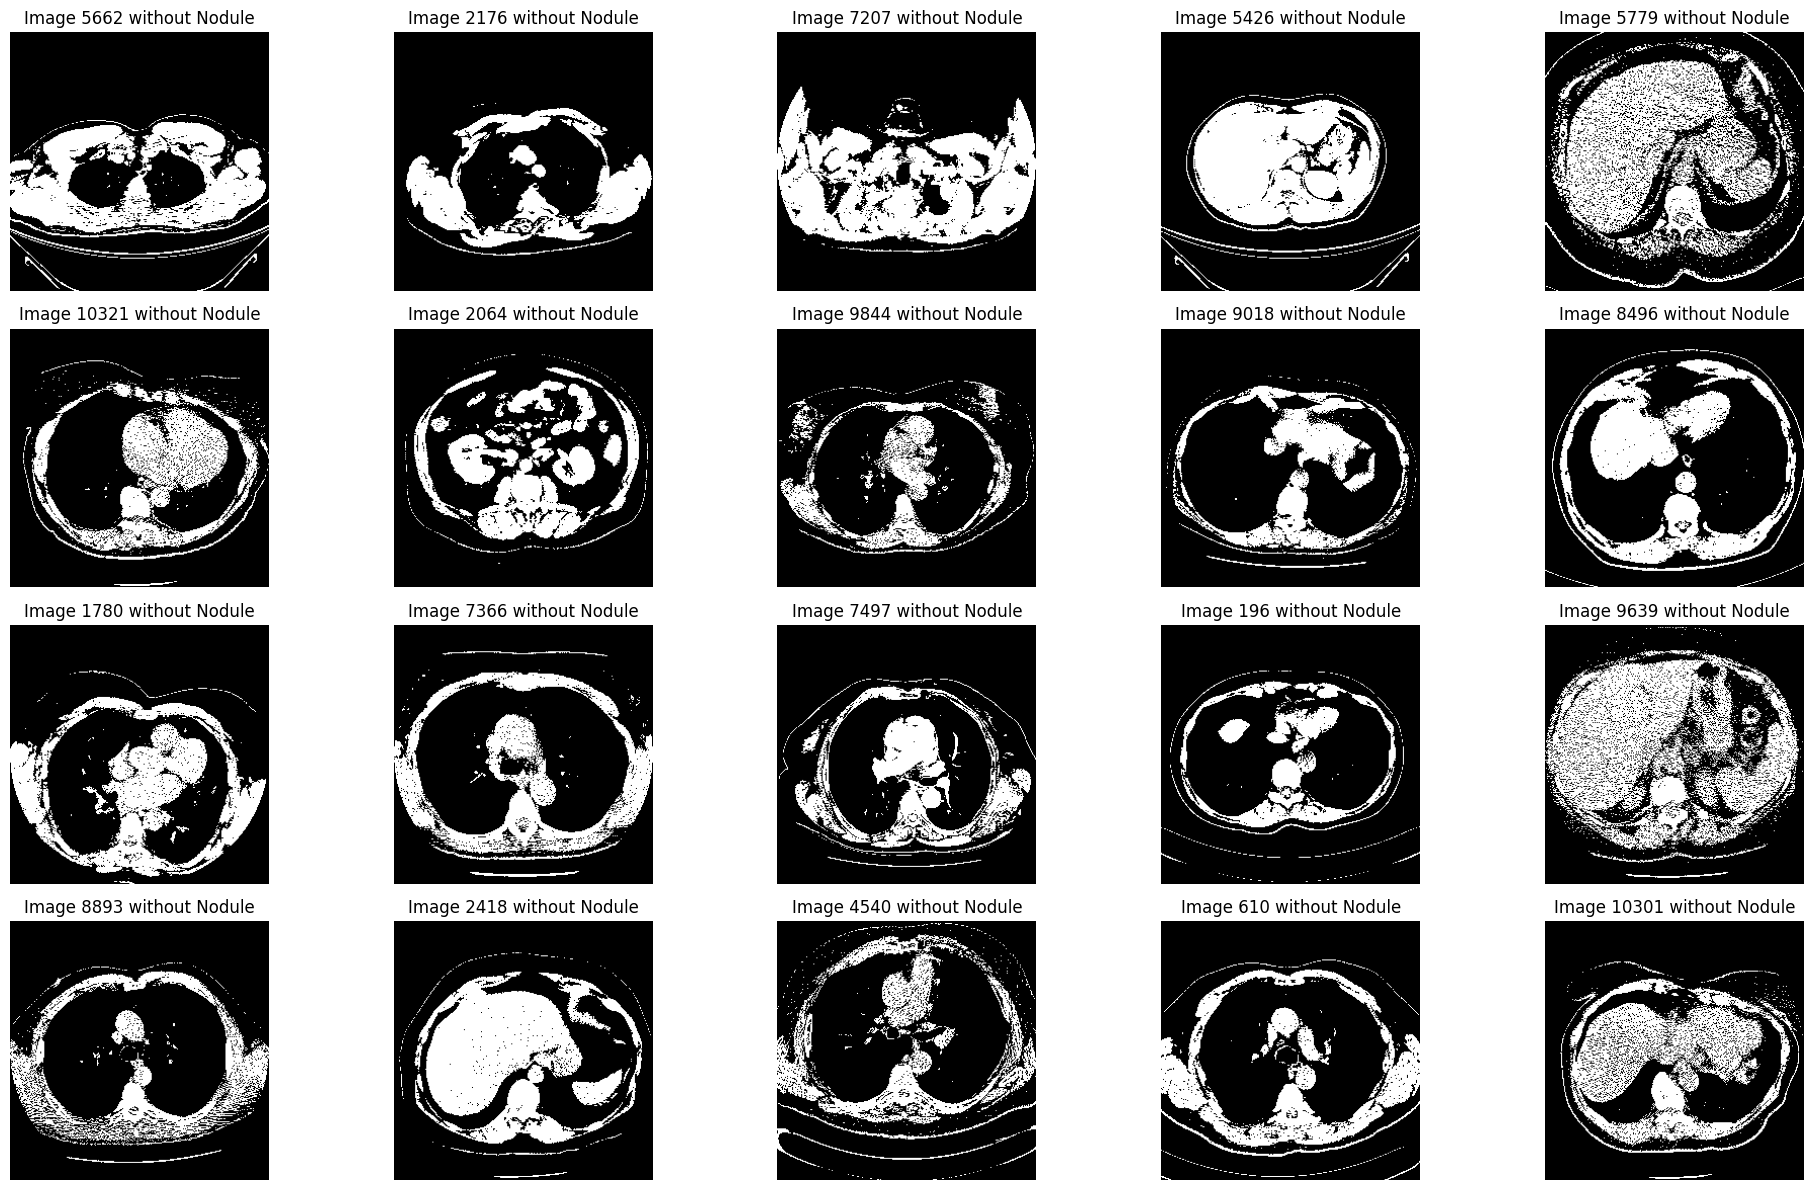

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Visualization functions
def clip_data(data):
    return np.clip(data, 0, 1)

def visualize_data_with_bboxes(original_images, bboxes, indices, classes):
    num_images = min(20, len(original_images))
    fig, axs = plt.subplots(4, 5, figsize=(20, 12))
    axs = axs.flatten()

    for i in range(num_images):
        image = clip_data(np.squeeze(original_images[i]))
        bbox = bboxes[i]
        cls = classes[i]

        ax = axs[i]
        ax.imshow(image, cmap="gray", vmin=0, vmax=1)
        if cls == 1:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.set_title(f"Image {indices[i]} with Nodule")
        else:
            ax.set_title(f"Image {indices[i]} without Nodule")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def preprocess_image(image):
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    if image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image

def preprocess_mask(mask):
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask, tf.float32)
    return mask

def random_data_generator(df, batch_size=20):
    df_with_nodules = df[df['class'] == 1]
    if df_with_nodules.empty:
        raise ValueError("No samples with nodules found in the dataset.")

    indices = np.random.choice(df.index, batch_size, replace=False)
    batch_df = df.loc[indices]
    images = np.array([img for img in batch_df['imagedata']])
    bboxes = np.array([bbox for bbox in batch_df['bbox']])
    classes = np.array([cls for cls in batch_df['class']])
    return images, bboxes, indices, classes

# Generate random data and visualize it
original_images, bboxes, indices, classes = random_data_generator(df_slices, batch_size=20)
visualize_data_with_bboxes(original_images, bboxes, indices, classes)



Counting our dataset and how is it divided before imputing in the model

In [ ]:
# Count the number of images with nodules and without nodules
num_images_with_nodules = df_slices[df_slices['class'] == 1].shape[0]
num_images_without_nodules = df_slices[df_slices['class'] == 0].shape[0]

print(f"Number of images with nodules: {num_images_with_nodules}")
print(f"Number of images without nodules: {num_images_without_nodules}")

# Verify the counts
assert num_images_with_nodules + num_images_without_nodules == len(df_slices), "Counts do not match total number of images"

Number of images with nodules: 240
Number of images without nodules: 10234


## Part 4: Building the Faster R-CNN Model
Create and compile the Faster R-CNN model with a VGG16 backbone

BACKBONES:

V6616 -> We keep this one

RESNET18 -> Tried it but the performance is not better

    def preprocess_image(image):
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    if image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)  # Repeat the single channel to make 3 channels


Tried to make the method of combining the channels and sum it, couldnt for sizing


This section contains also the preprocessing steps for images, applies data augmentation techniques to improve the model, and provides a function to debug the preprocessing steps by visualizing the images that are being used in the model


58889256/58889256 [==============================] - 2s 0us/step


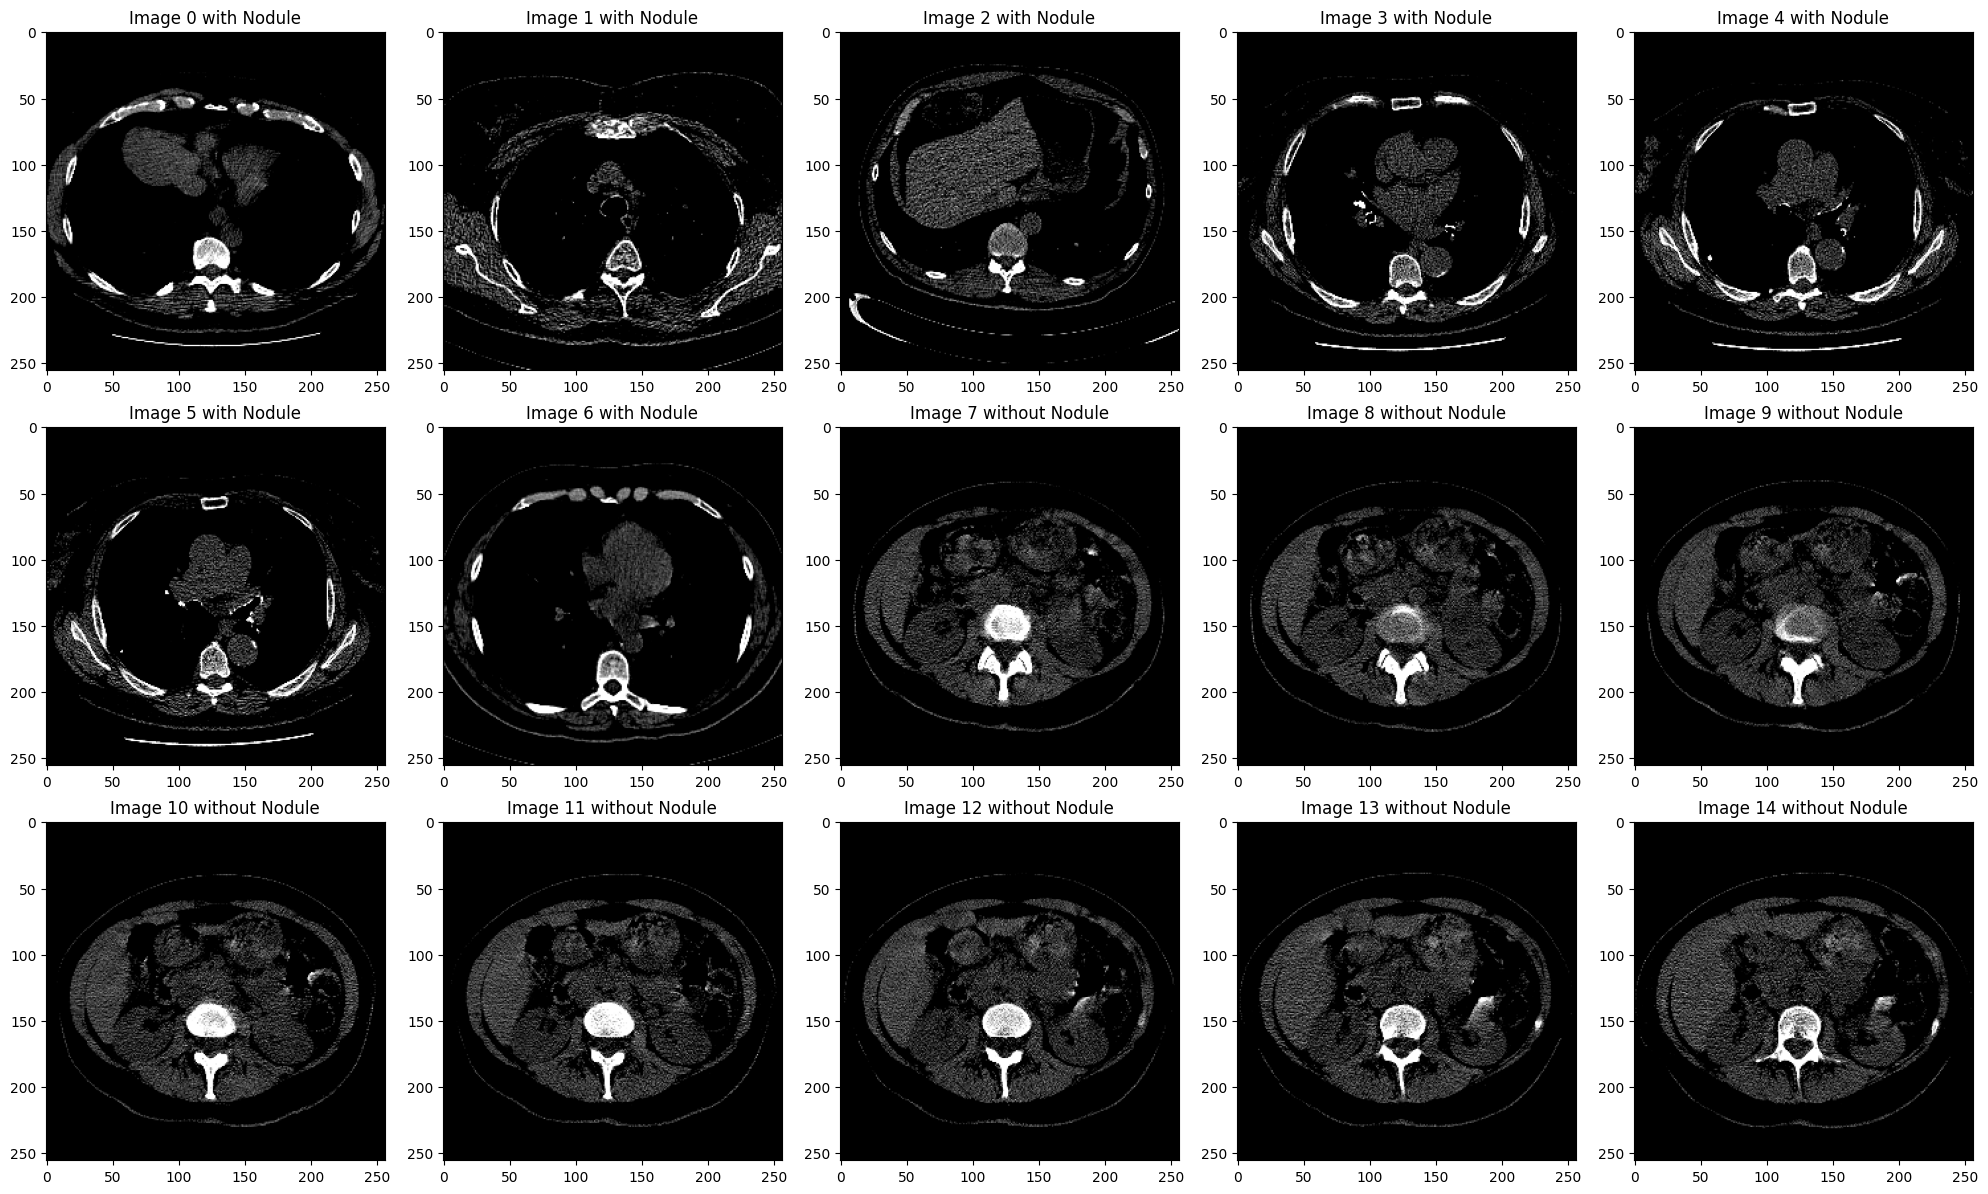

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

# Define the Faster R-CNN model with VGG16 backbone and FPN
def create_faster_rcnn_model():
    input_shape = (256, 256, 3)
    input_image = tf.keras.layers.Input(shape=input_shape)

    # Backbone model (VGG16)
    backbone = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=input_image)

    # Create FPN layers
    c3_output = backbone.get_layer("block3_conv3").output
    c4_output = backbone.get_layer("block4_conv3").output
    c5_output = backbone.get_layer("block5_conv3").output

    p5 = tf.keras.layers.Conv2D(256, (1, 1), kernel_initializer='he_normal', name="fpn_p5")(c5_output)
    p4 = tf.keras.layers.Add(name="fpn_p4")([
        tf.keras.layers.Conv2D(256, (1, 1), kernel_initializer='he_normal')(c4_output),
        tf.keras.layers.UpSampling2D(size=(2, 2))(p5)
    ])
    p3 = tf.keras.layers.Add(name="fpn_p3")([
        tf.keras.layers.Conv2D(256, (1, 1), kernel_initializer='he_normal')(c3_output),
        tf.keras.layers.UpSampling2D(size=(2, 2))(p4)
    ])

    p3 = tf.keras.layers.Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(p3)
    p4 = tf.keras.layers.Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(p4)
    p5 = tf.keras.layers.Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(p5)

    # Region Proposal Network (RPN)
    rpn_cls = tf.keras.layers.Conv2D(9 * 2, (1, 1), activation="sigmoid", name="rpn_cls")(p3)
    rpn_reg = tf.keras.layers.Conv2D(9 * 4, (1, 1), name="rpn_reg")(p3)

    # Classification and regression heads
    flatten = tf.keras.layers.Flatten()(p5)
    fc1 = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(flatten)
    fc1 = tf.keras.layers.BatchNormalization()(fc1)
    fc1 = tf.keras.layers.Dropout(0.5)(fc1)

    fc2 = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(fc1)
    fc2 = tf.keras.layers.BatchNormalization()(fc2)
    fc2 = tf.keras.layers.Dropout(0.5)(fc2)

    classification_output = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_head')(fc2)
    box_regression_output = tf.keras.layers.Dense(4, activation='linear', name='box_regression_head')(fc2)

    model = tf.keras.models.Model(inputs=input_image, outputs=[rpn_cls, rpn_reg, classification_output, box_regression_output])

    # Custom Focal Loss for class imbalance
    def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
        y_true = tf.cast(y_true, tf.float32)
        alpha_factor = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        focal_weight = tf.where(tf.equal(y_true, 1), 1 - y_pred, y_pred)
        focal_weight = alpha_factor * tf.pow(focal_weight, gamma)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(focal_weight * bce)

    # Compile the model with SGD optimizer and gradient clipping
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.9, clipvalue=1.0)
    model.compile(optimizer=optimizer,
                  loss={'rpn_cls': 'binary_crossentropy',
                        'rpn_reg': 'mean_squared_error',
                        'classification_head': focal_loss,
                        'box_regression_head': 'mean_squared_error'},
                  metrics={'rpn_cls': 'accuracy',
                           'classification_head': 'accuracy',
                           'rpn_reg': 'mse',
                           'box_regression_head': 'mse'})
    return model

model = create_faster_rcnn_model()

# Correct image preprocessing function
def preprocess_image(image):
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    if image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)  # Repeat the single channel to make 3 channels
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # Normalize image to [0, 1]
    image = np.clip(image, 0, 1)  # Ensure the values are within the valid range
    return image

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Correct data generator function with data augmentation
def data_generator(df, batch_size=20, augment=False):
    while True:
        indices = np.random.choice(df.index, batch_size)
        batch_df = df.loc[indices]
        images = np.array([preprocess_image(img) for img in batch_df['imagedata']])

        if augment:
            # Apply augmentation to nodule images
            nodule_indices = batch_df['class'] == 1
            images[nodule_indices] = data_augmentation(images[nodule_indices])

        x = tf.convert_to_tensor(images, dtype=tf.float32)
        bboxes = np.array(batch_df['bbox'].tolist())
        y = {
            'rpn_cls': tf.convert_to_tensor(np.random.randint(0, 2, (batch_size, 64, 64, 18)), dtype=tf.float32),
            'rpn_reg': tf.convert_to_tensor(np.random.rand(batch_size, 64, 64, 36), dtype=tf.float32),
            'classification_head': tf.convert_to_tensor(np.array(batch_df['class']).reshape(-1, 1), dtype=tf.float32),
            'box_regression_head': tf.convert_to_tensor(bboxes, dtype=tf.float32)
        }
        yield x, y


# Debug: Verify preprocessed images
def debug_preprocessing(df, num_images=15):
    rows = (num_images + 4) // 5  # calculate number of rows needed
    plt.figure(figsize=(20, 4 * rows))
    for i in range(num_images):
        img = preprocess_image(df['imagedata'].iloc[i])
        plt.subplot(rows, 5, i+1)
        plt.imshow(np.squeeze(img), cmap='gray')
        plt.title(f"Image {df.index[i]} with Nodule" if df['class'].iloc[i] == 1 else f"Image {df.index[i]} without Nodule")
    plt.tight_layout()
    plt.show()

# Display preprocessed images for debugging
debug_preprocessing(df_slices, num_images=15)



In [ ]:
# Count the number of images with nodules and without nodules
num_images_with_nodules = df_slices[df_slices['class'] == 1].shape[0]
num_images_without_nodules = df_slices[df_slices['class'] == 0].shape[0]

print(f"Number of images with nodules: {num_images_with_nodules}")
print(f"Number of images without nodules: {num_images_without_nodules}")

Number of images with nodules: 240
Number of images without nodules: 10234


## Part 5: Training and Evaluation Setup
This part sets up the training and evaluation process, including custom callbacks and learning rate scheduling.



In [ ]:
### Part 5: Training and Evaluation Setup

# This part sets up the training and evaluation process, including custom callbacks and learning rate scheduling.

# Create training and validation datasets
train_dataset = data_generator(df_slices, batch_size=20, augment=True)
val_dataset = data_generator(df_slices, batch_size=20, augment=False)

# Custom callback to calculate mAP, visualize predictions, and save best weights
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.best_weights = None
        self.best_mAP = 0

    def on_epoch_end(self, epoch, logs=None):
        val_images, val_targets = next(val_dataset)  # Get a batch of validation data
        preds = self.model.predict(val_images)  # Predict on the validation data

        # Calculate mAP for validation data
        mAP = average_precision_score(val_targets['classification_head'], preds[2])
        precision, recall, f1, _ = precision_recall_fscore_support(val_targets['classification_head'], np.round(preds[2]), average='binary')
        print(f"Validation mAP: {mAP}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")

        # Save best weights if mAP improves
        if mAP > self.best_mAP:
            self.best_mAP = mAP
            self.best_weights = self.model.get_weights()
            self.model.save_weights('best_model_weights.h5')
            print("Best weights saved.")

        # Visualize a few predictions
        for i in range(3):
            img = val_images[i]
            true_box = val_targets['box_regression_head'][i]
            pred_box = preds[3][i]

            plt.figure()
            plt.imshow(np.squeeze(img), cmap='gray')
            plt.gca().add_patch(plt.Rectangle((true_box[0], true_box[1]), true_box[2] - true_box[0], true_box[3] - true_box[1], fill=False, edgecolor='green', linewidth=2))
            plt.gca().add_patch(plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2] - pred_box[0], pred_box[3] - pred_box[1], fill=False, edgecolor='red', linewidth=2))
            plt.show()

# Learning rate scheduler callback
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=20,
                    steps_per_epoch=50,
                    validation_steps=10,
                    callbacks=[CustomCallback(), lr_scheduler])

### Part 6: Plotting Training Metrics

# This part plots the training loss and validation metrics for better visualization and understanding of model performance.

# Plot the training loss and validation metrics
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['classification_head_accuracy'])
plt.plot(history.history['val_classification_head_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate the model on validation data, loads the best weights for testing, and visualizes predictions.

# Evaluate the model on validation data
eval_results = model.evaluate(val_dataset, steps=10)
print("Loss, RPN Classification Accuracy, RPN Regression MSE, Classification Accuracy, Box Regression MSE:", eval_results)

# Load best weights for testing
model.load_weights('best_model_weights.h5')

# Testing the model
test_images, test_targets = next(val_dataset)
preds = model.predict(test_images)

# Generate confusion matrix for classification results
true_classes = np.array(test_targets['classification_head'])
pred_classes = np.round(preds[2])
cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Nodule", "Nodule"])
disp.plot(cmap=plt.cm.Blues)
plt.show()


Epoch 1/20
 3/50 [>.............................] - ETA: 10:04 - loss: 548.1021 - rpn_cls_loss: 8.1095 - rpn_reg_loss: 405.8264 - classification_head_loss: 0.3393 - box_regression_head_loss: 133.8268 - rpn_cls_accuracy: 0.0056 - rpn_reg_mse: 405.8264 - classification_head_accuracy: 0.4667 - box_regression_head_mse: 133.8268

In [ ]:
##ERRORS TO IMRPOVE:

- CLASS IMBALANCE
- TASK COMPLEXITY
- TRAINING PROCESS
- DATASET: BALANCE AND MORE DATA (MORE COMPUTATIONAL RESOURCES!)
- ENHANCE HYPERPARAMETER SETTINGS

## TESTING PART


## Part 7: Testing and Evaluation on a Separate Subset
This loads and processes a separate subset of the dataset for testing the model. We evaluate the model's performance on this test set, visualize predictions, and plot the FROC curve


In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Function to preprocess and save images for testing
def preprocess_image(image):
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    if image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image

# Function to load images and determine if they contain nodules
def load_images_with_nodules(file_list, annotations_df, target_size=(256, 256)):
    data = []
    for img_file in tqdm(file_list):
        mini_df = annotations_df[annotations_df["file"] == img_file]
        itk_img = sitk.ReadImage(img_file)
        img_array = sitk.GetArrayFromImage(itk_img)
        origin = np.array(itk_img.GetOrigin())
        spacing = np.array(itk_img.GetSpacing())
        original_size = img_array.shape[1:3]

        if mini_df.shape[0] > 0:
            for _, row in mini_df.iterrows():
                node_x, node_y, node_z = row["coordX"], row["coordY"], row["coordZ"]
                diam = row["diameter_mm"]
                center = np.array([node_x, node_y, node_z])
                i_z = int(np.rint((node_z - origin[2]) / spacing[2]))

                if 0 <= i_z < img_array.shape[0]:  # Check if the z-index is within the slice range
                    bbox = convert_to_2d_bounding_box(center, diam, spacing, origin)
                    img_resized = cv2.resize(img_array[i_z], target_size, interpolation=cv2.INTER_AREA)

                    # Scale bounding box coordinates to match resized image
                    scale_x = target_size[0] / original_size[1]
                    scale_y = target_size[1] / original_size[0]
                    bbox_resized = [int(bbox[0] * scale_x), int(bbox[1] * scale_y), int(bbox[2] * scale_x), int(bbox[3] * scale_y)]

                    data.append([row["seriesuid"], i_z, img_resized, bbox_resized, 1])  # 1 for nodule class
        else:
            for i in range(img_array.shape[0]):
                img_resized = cv2.resize(img_array[i], target_size, interpolation=cv2.INTER_AREA)
                data.append([img_file.split('/')[-1], i, img_resized, [0, 0, 0, 0], 0])  # 0 for non-nodule class
    return pd.DataFrame(data, columns=["seriesuid", "sliceindex", "imagedata", "bbox", "class"])

# Testing on subset9
test_file_path = "/content/drive/Shareddrives/IA DL_project/ML IA/LUNA16/subsets/subset9"
test_file_list = glob(test_file_path + "/*.mhd")

annotations_path = "/content/drive/Shareddrives/IA DL_project/ML IA/LUNA16/annotations.csv"
df_node = pd.read_csv(annotations_path)
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(test_file_list, file_name))
df_node = df_node.dropna(subset=["file"])

# Combine nodules and non-nodules
df_slices_test = load_images_with_nodules(test_file_list, df_node)

# Data generator for test dataset
def data_generator_test(df, batch_size=20):
    while True:
        indices = np.random.choice(df.index, batch_size)
        batch_df = df.loc[indices]
        images = np.array([preprocess_image(img) for img in batch_df['imagedata']])
        x = tf.convert_to_tensor(images, dtype=tf.float32)
        bboxes = np.array(batch_df['bbox'].tolist())
        y = {
            'rpn_cls': tf.convert_to_tensor(np.random.randint(0, 2, (batch_size, 64, 64, 18)), dtype=tf.float32),
            'rpn_reg': tf.convert_to_tensor(np.random.rand(batch_size, 64, 64, 36), dtype=tf.float32),
            'classification_head': tf.convert_to_tensor(np.array(batch_df['class']).reshape(-1, 1), dtype=tf.float32),
            'box_regression_head': tf.convert_to_tensor(bboxes, dtype=tf.float32)
        }
        yield x, y

test_dataset = data_generator_test(df_slices_test, batch_size=20)

# Evaluate on test dataset
test_results = model.evaluate(test_dataset, steps=10)
print("Test Loss, RPN Classification Accuracy, RPN Regression MSE, Classification Accuracy, Box Regression MSE:", test_results)

# Visualize predictions on test dataset
test_images, test_targets = next(test_dataset)
test_preds = model.predict(test_images)

for i in range(3):
    img = test_images[i]
    true_box = test_targets['box_regression_head'][i]
    pred_box = test_preds[3][i]

    plt.figure()
    plt.imshow(np.squeeze(img), cmap='gray')
    plt.gca().add_patch(plt.Rectangle((true_box[0], true_box[1]), true_box[2] - true_box[0], true_box[3] - true_box[1], fill=False, edgecolor='green', linewidth=2))
    plt.gca().add_patch(plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2] - pred_box[0], pred_box[3] - pred_box[1], fill=False, edgecolor='red', linewidth=2))
    plt.show()

# Plot FROC curve
def plot_froc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('FROC Curve')
    plt.show()

# Calculate FROC curve for test dataset
y_true = test_targets['classification_head']
y_scores = test_preds[2]
plot_froc_curve(y_true, y_scores)



###
# Load the best weights before testing
model.load_weights("best_model_weights.h5")

# Evaluate on test dataset
test_results = model.evaluate(test_dataset, steps=10)
print("Test Loss, RPN Classification Accuracy, RPN Regression MSE, Classification Accuracy, Box Regression MSE:", test_results)

# Visualize predictions on test dataset
test_images, test_targets = next(test_dataset)
test_preds = model.predict(test_images)

for i in range(3):
    img = test_images[i]
    true_box = test_targets['box_regression_head'][i]
    pred_box = test_preds[3][i]

    plt.figure()
    plt.imshow(np.squeeze(img), cmap='gray')
    plt.gca().add_patch(plt.Rectangle((true_box[0], true_box[1]), true_box[2] - true_box[0], true_box[3] - true_box[1], fill=False, edgecolor='green', linewidth=2))
    plt.gca().add_patch(plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2] - pred_box[0], pred_box[3] - pred_box[1], fill=False, edgecolor='red', linewidth=2))
    plt.show()

# Plot FROC curve
def plot_froc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('FROC Curve')
    plt.show()

# Calculate FROC curve for test dataset
y_true = test_targets['classification_head']
y_scores = test_preds[2]
plot_froc_curve(y_true, y_scores)

# Plot confusion matrix for test dataset
y_true_cls = test_targets['classification_head']
y_pred_cls = test_preds[2] > 0.5  # Threshold the sigmoid output
cm = confusion_matrix(y_true_cls, y_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-nodule", "Nodule"])
disp.plot(cmap=plt.cm.Blues)
plt.show()
